In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

# Monte Carlo Simulations in Finance

## Simulating Stock Price Dynamics Using Geometric Brownian Motion

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

1- Define parameters for downloading data

In [7]:
RISKY_ASSET = 'MSFT'
START_DATE = '2018-12-31'
END_DATE = '2019-07-31'

2- Download data from Yahoo Finance

In [8]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE)
print(f'Downloaded {df.shape[0]} rowns of data')

df.head()

[*********************100%%**********************]  1 of 1 completed
Downloaded 146 rowns of data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,101.290001,102.400002,100.440002,101.570000,96.272545,33173800
2019-01-02,99.550003,101.750000,98.940002,101.120003,95.846008,35329300
2019-01-03,100.099998,100.190002,97.199997,97.400002,92.320030,42579100
2019-01-04,99.720001,102.510002,98.930000,101.930000,96.613762,44060600
2019-01-07,101.639999,103.269997,100.980003,102.059998,96.736992,35656100


3- Calculate daily returns

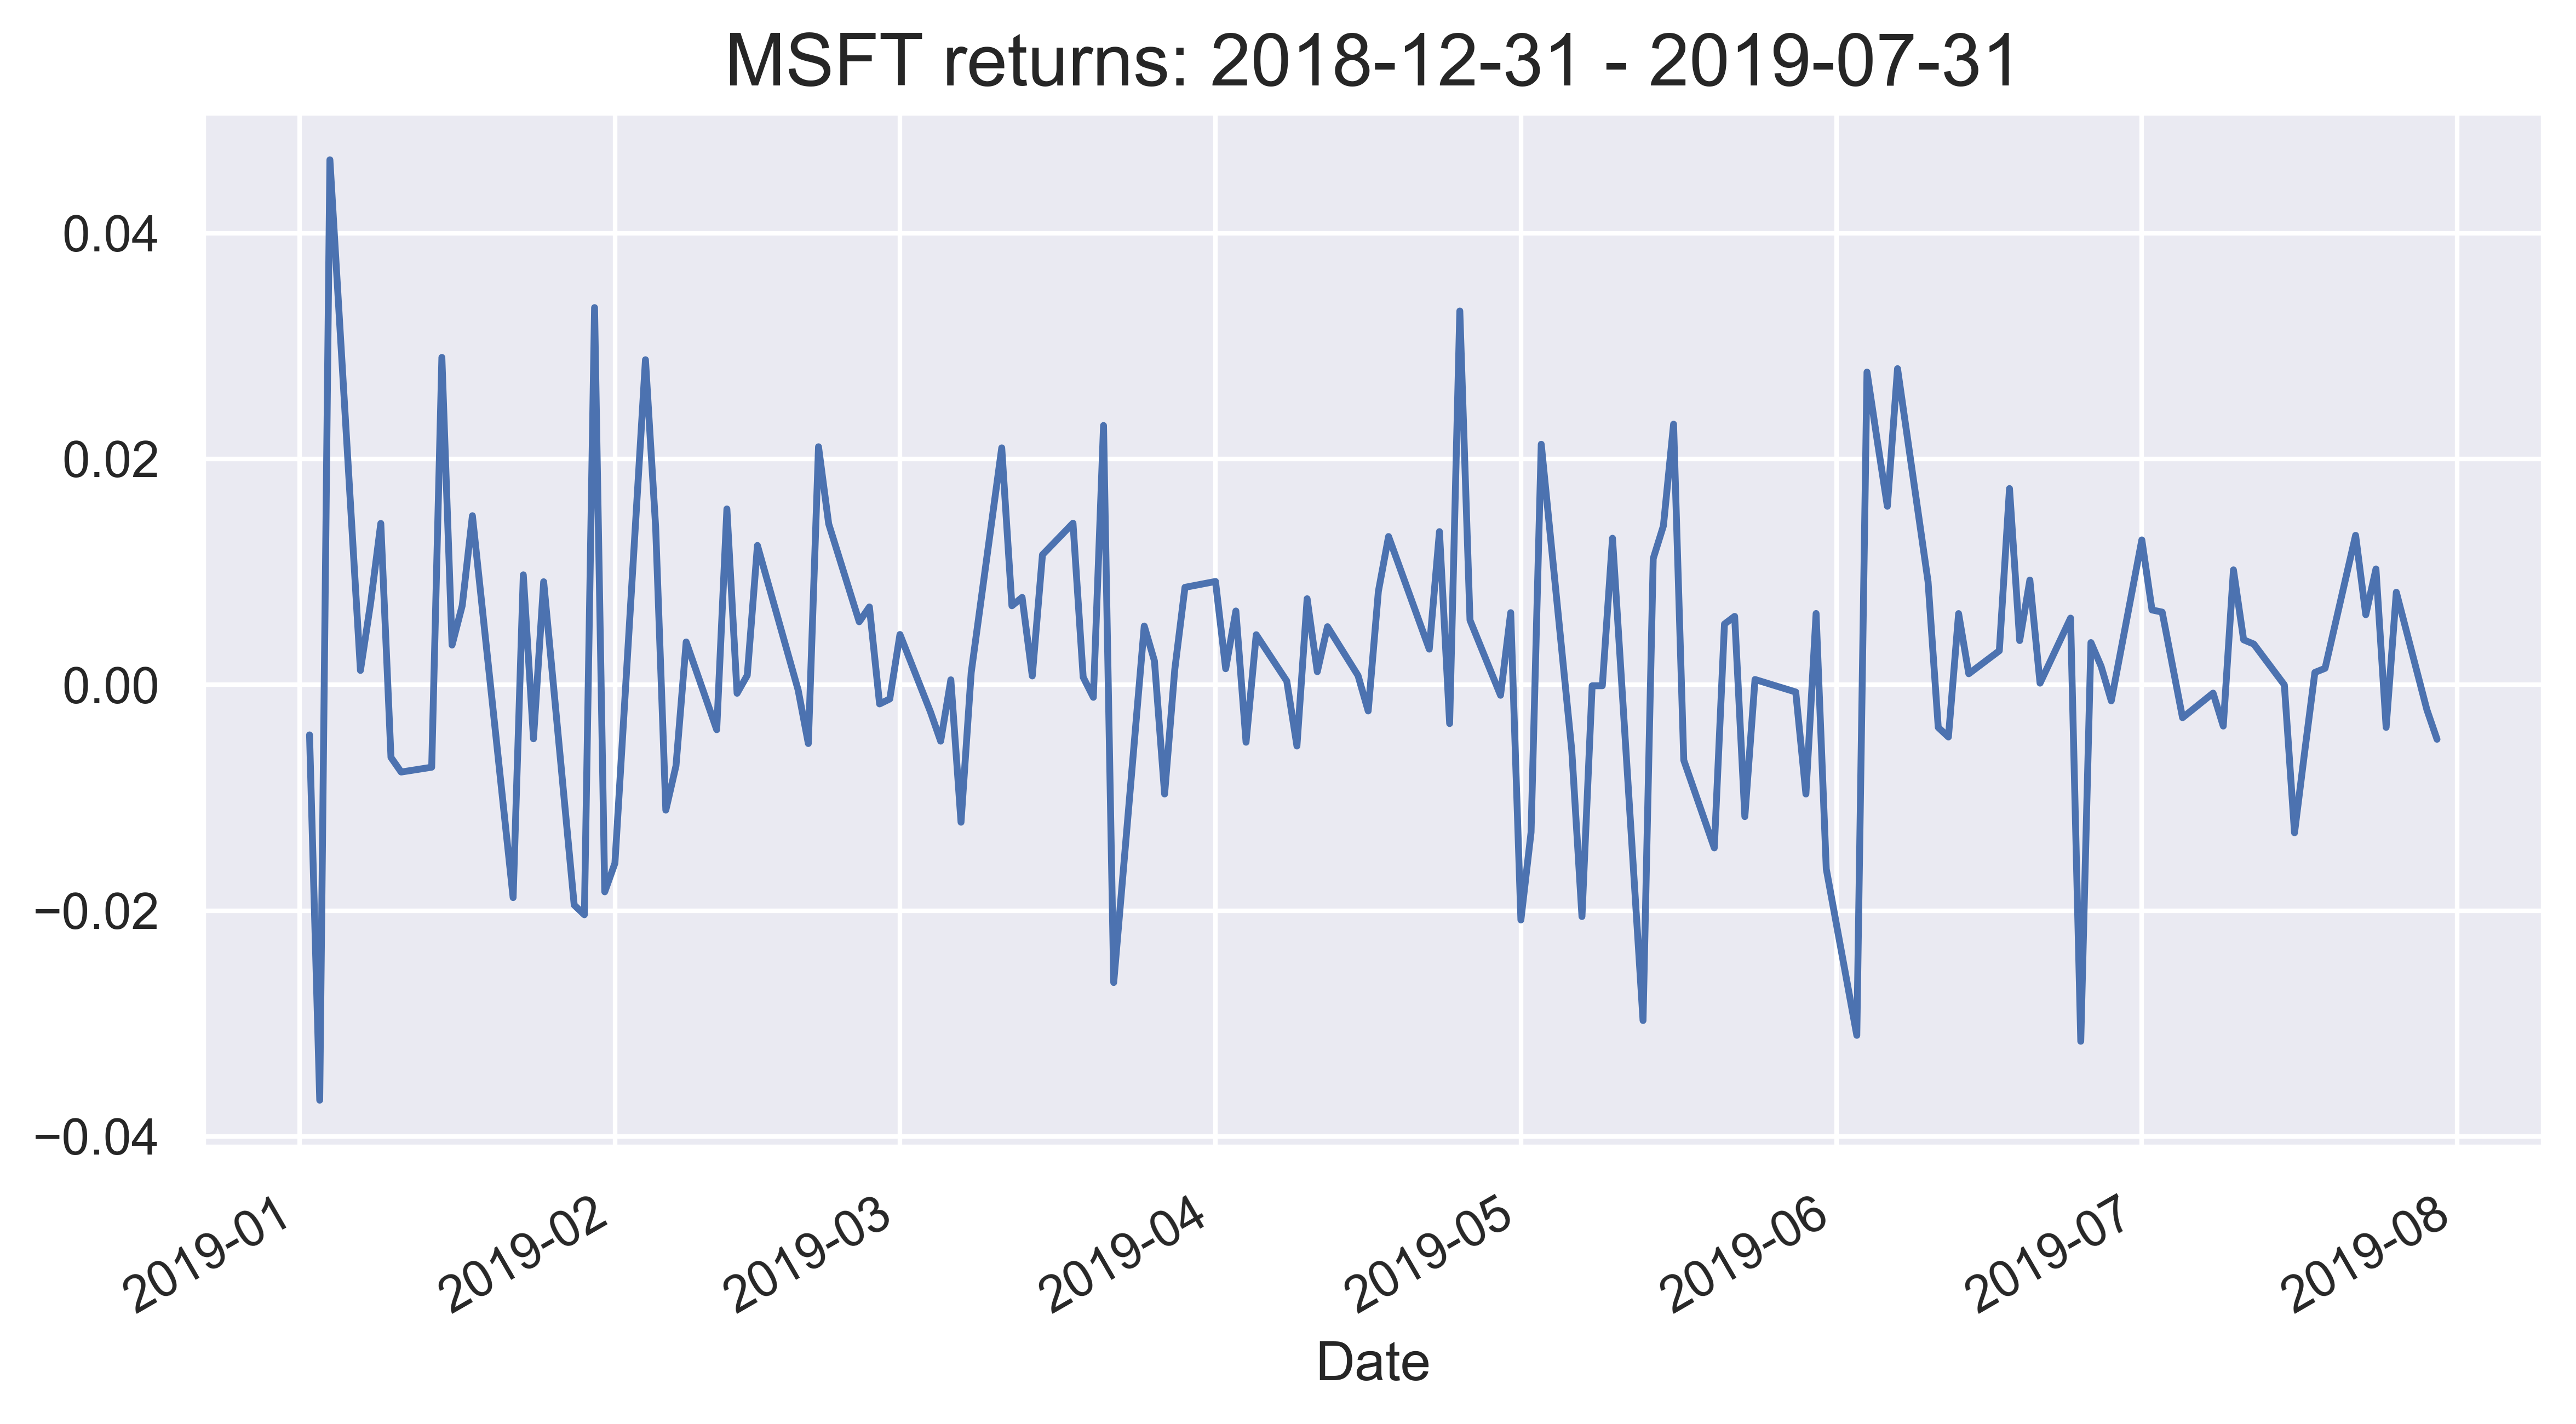

Average return: 0.24%


In [10]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', fontsize=16)

plt.tight_layout()
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

4- Split data into the training and test sets

In [11]:
train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

5- Specify the parameters of the simulation

In [12]:
T = len(test)
N = len(test)
s_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

6- Define the function used for simulation

In [18]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ----------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''

    np.random.seed(random_seed)

    dt = T / N
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp(((mu - 0.5 * sigma ** 2) * time_steps + sigma * W))
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

7- Run the simulations

In [19]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

8- Plot simulation result:

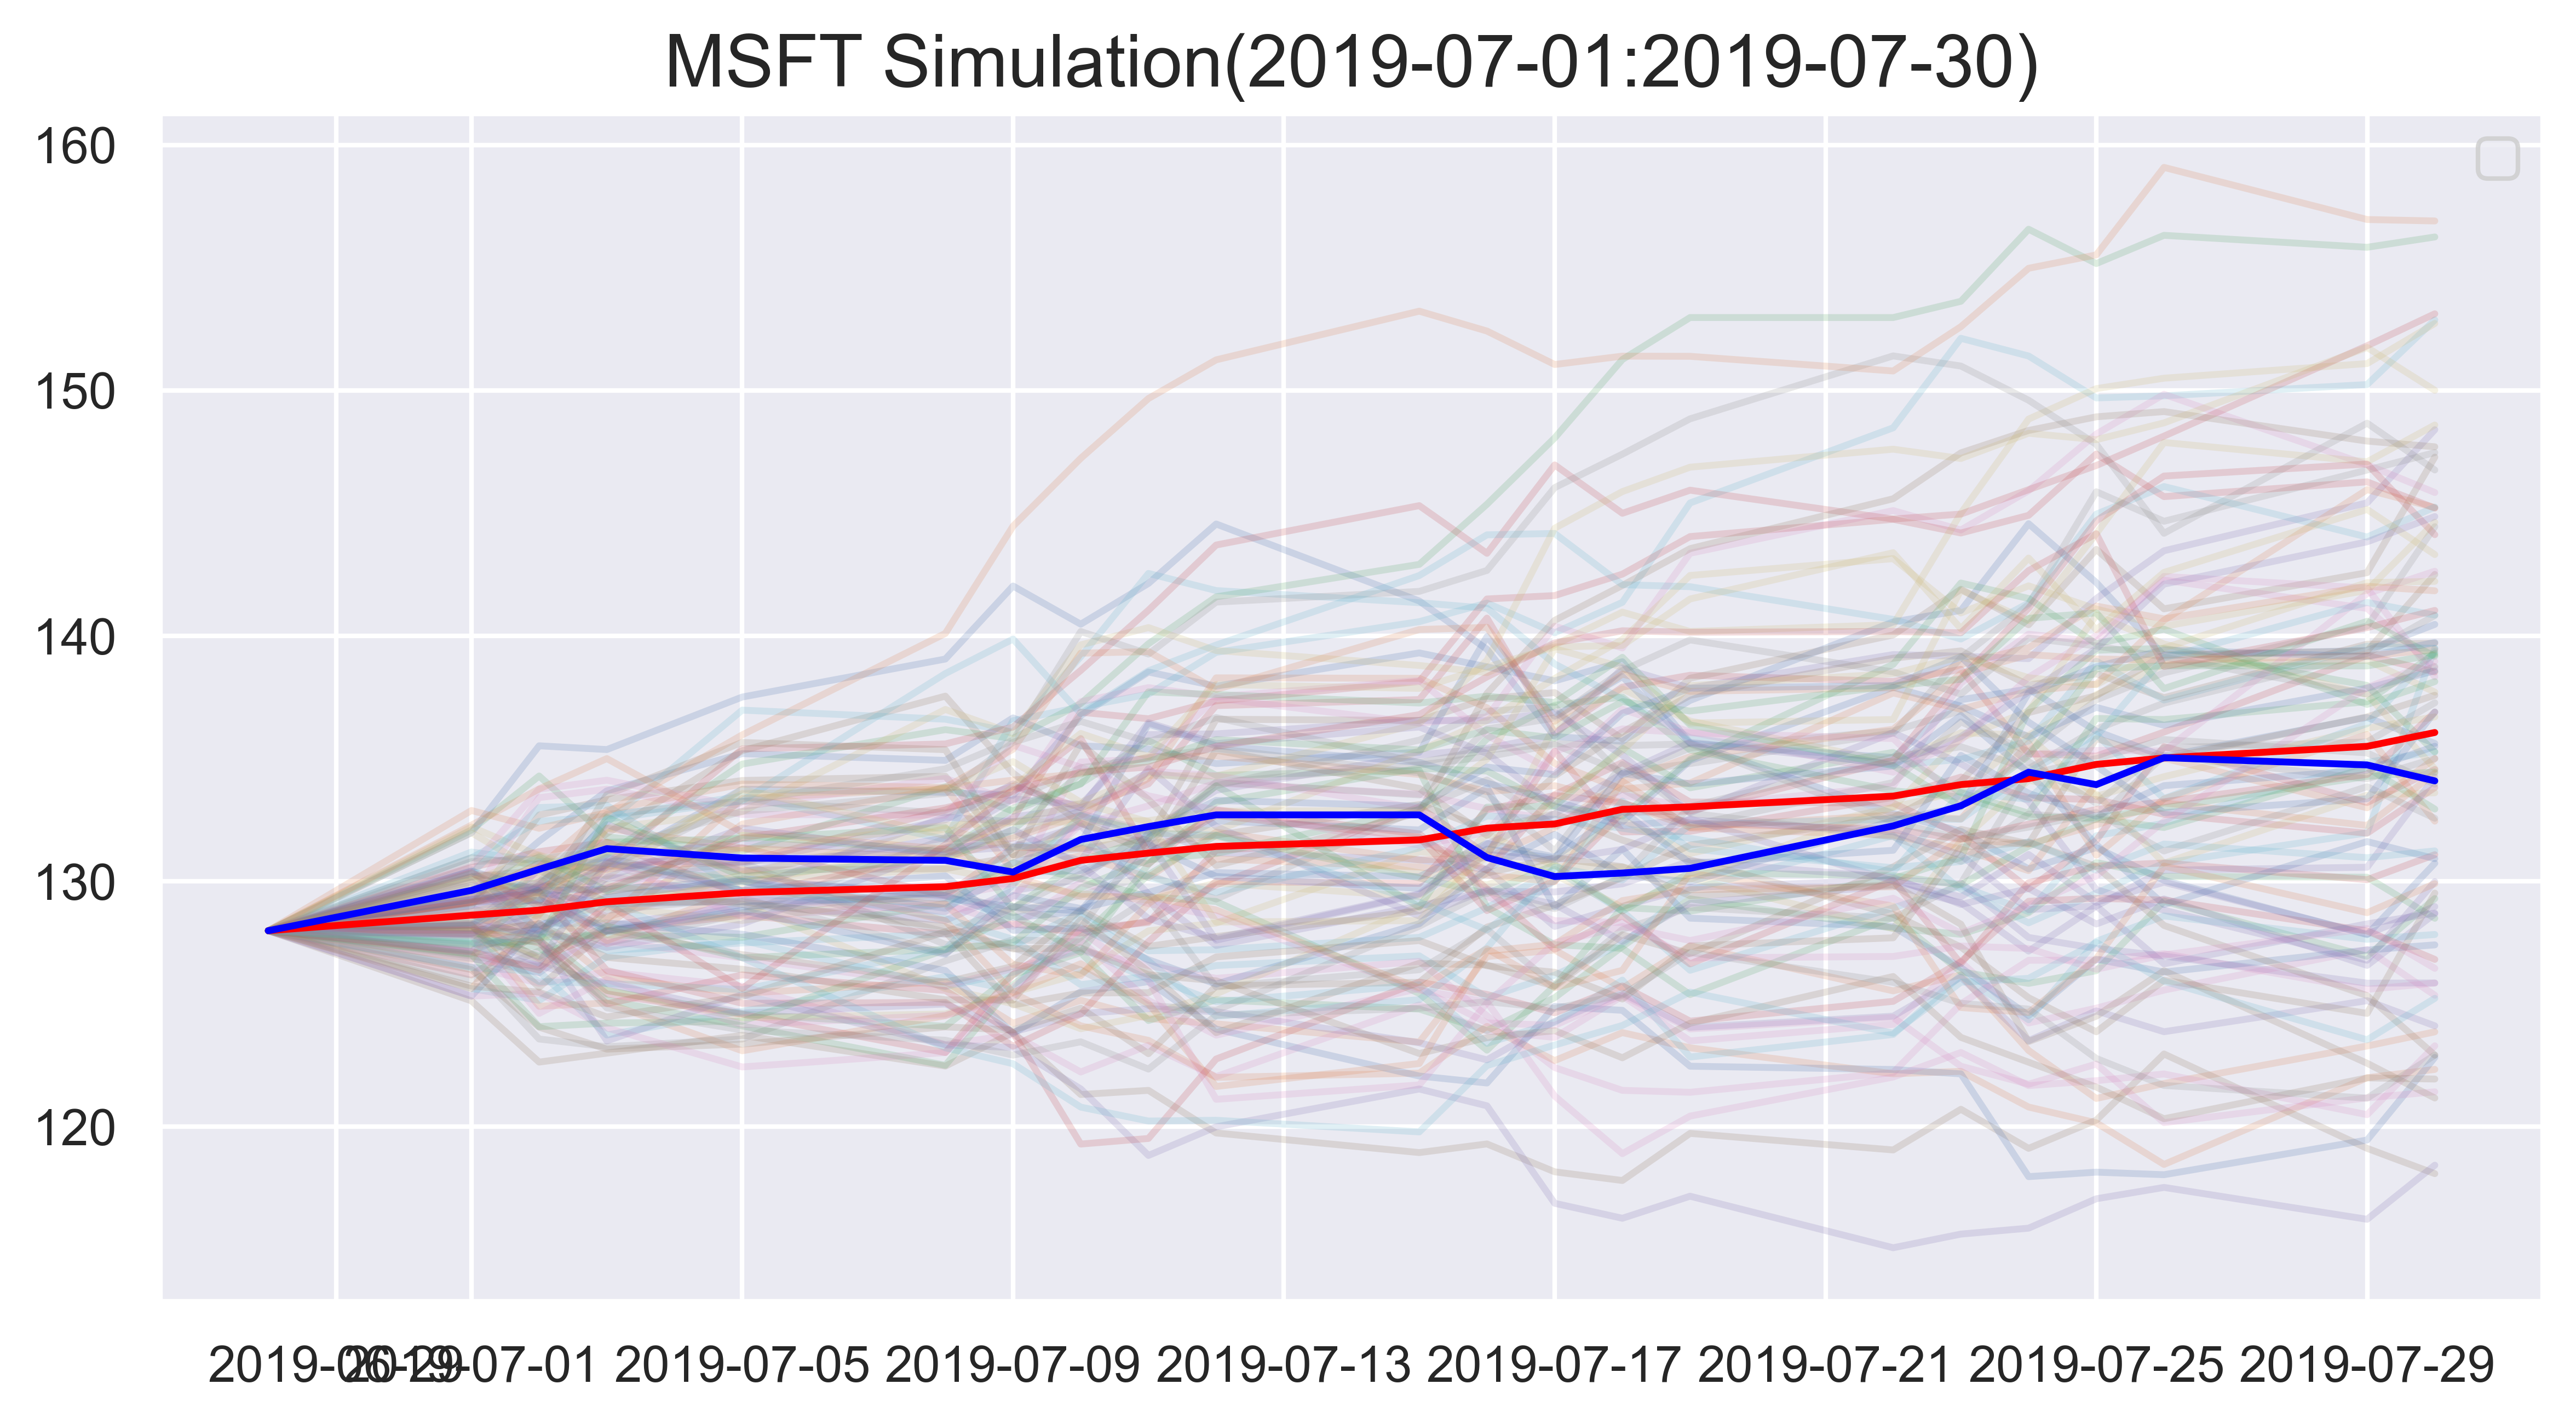

In [23]:
# Prepare objects for plotting
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation' 
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)

# Plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1 = ax.plot(index, gbm_simulations_df.mean(axis=1), color='red')
line_2 = ax.plot(index, adj_close[last_train_date:last_test_date], color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()

### There`s More

In [25]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

143 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ----------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''

    np.random.seed(random_seed)

    # time increment
    dt = T / N

    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale=np.sqrt(dt), size=(int(n_sims/2), N+1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else:
        dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N+1))

    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, axis=1))
    S_t[:, 0] = s_0

    return S_t

In [27]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

87 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

69.8 µs ± 540 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
